In [2]:
import pandas as pd
import numpy as np
import os
import sys

In [4]:
import pickle
from sklearn.metrics import roc_auc_score

In [6]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

In [ ]:
from scAAnet.tools import programDEG, save_df_to_npz, load_df_from_npz

In [ ]:
from gepsim import gepsim

# Simulate data for benchmarking DEG analysis

In [ ]:
! mkdir ../Simulation_no
! mkdir ../Simulation_no_results

In [ ]:
## Main simulation parameters
ngenes = 2000
descale = 1.0
ndoublets = 0
K = 4
ncells = 3000
deprob = .1
dedownprob = 0.5
bound_prob = 0.5
expoutprob=0.
de_overlap = False # Simulate data with no overlapped DEGs among GEPs
cluster = False
lams = ['Inf', '0.3', '0.1', '0.01']

for lam in lams:
    
    if lam == "Inf":
        zinf = False
        zidecay = np.inf 
    else:
        zinf = True
        zidecay = float(lam)
        
    ## Create output directory structure
    if zinf:
        if not os.path.exists('../Simulation_no/ZINB_mean_%.2f/'%zidecay):
            os.mkdir('../Simulation_no/ZINB_mean_%.2f/'%zidecay)
            os.mkdir('../Simulation_no/ZINB_mean_%.2f/deloc_1.00'%zidecay)
            os.mkdir('../Simulation_no/ZINB_mean_%.2f/deloc_0.75'%zidecay)
            os.mkdir('../Simulation_no/ZINB_mean_%.2f/deloc_0.50'%zidecay)
    else:
        if not os.path.exists('../Simulation_no/NB_mean/'):
            os.mkdir('../Simulation_no/NB_mean')
            os.mkdir('../Simulation_no/NB_mean/deloc_1.00')
            os.mkdir('../Simulation_no/NB_mean/deloc_0.75')
            os.mkdir('../Simulation_no/NB_mean/deloc_0.50')
        if not os.path.exists('../Simulation_no/Basic/'):
            os.mkdir('../Simulation_no/Basic')
            os.mkdir('../Simulation_no/Basic/deloc_1.00')
            os.mkdir('../Simulation_no/Basic/deloc_0.75')
            os.mkdir('../Simulation_no/Basic/deloc_0.50')

    if zinf:
        outdirbase = '../Simulation_no/ZINB_mean_%.2f/deloc_%.2f/Seed_%d'
    else:
        outdirbase = '../Simulation_no/NB_mean/deloc_%.2f/Seed_%d'
        basicdirbase = '../Simulation_no/Basic/deloc_%.2f/Seed_%d'

    # Simulation
    seedmap = {1.00:[9485,13657,18839,19052,22856,22517,26118,29975,4090,9474],
              0.75:[10864, 31986, 2192, 13703, 407, 9530, 27377, 22446, 24855, 25632],
              0.50:[4902, 15450, 9925, 22625, 27565, 19415, 19080, 24981, 3290, 18286]}

    for deloc in [0.50, 0.75, 1.00]:
        for seed in seedmap[deloc]:

            print(deloc, seed)

            if zinf:
                outdir = outdirbase % (zidecay, deloc, seed)
            else:
                outdir = outdirbase % (deloc, seed)
                basicdir = basicdirbase % (deloc, seed)
                if not os.path.exists(basicdir):
                    os.mkdir(basicdir)
            if not os.path.exists(outdir):
                os.mkdir(outdir)

            simulator = gepsim(ngenes=ngenes, ncells=ncells, ngroups=K, libloc=7.64, libscale=0.78,
                                mean_rate=7.68, mean_shape=0.34, expoutprob=expoutprob,
                                expoutloc=6.15, expoutscale=0.49, boundprob=bound_prob,
                                diffexpprob=deprob, diffexpdownprob=dedownprob, diffexploc=deloc, diffexpscale=descale,
                                bcv_dispersion=0.448, bcv_dof=22.087, ndoublets=ndoublets,
                                seed=seed, zeroinflate=zinf, zidecay=zidecay, de_overlap=de_overlap, cluster=cluster)
            simulator.simulate()

            if zinf:
                counts = simulator.zicounts
            else:
                counts = simulator.counts

            if zinf==False:
                save_df_to_npz(simulator.cellparams, '%s/cellparams' % basicdir)
                save_df_to_npz(simulator.geneparams, '%s/geneparams' % basicdir)
                save_df_to_npz(simulator.counts, '%s/truecounts' % basicdir)
                save_df_to_npz(simulator.cellgenemean, '%s/cellgenemean' % basicdir)

            save_df_to_npz(counts, '%s/counts' % outdir)


# Run designed DEG tests on simulated data

In [ ]:
# Generate directories to save results
lams = ['Inf', '0.3', '0.1', '0.01']

for lam in lams:
    if lam == "Inf":
        if not os.path.exists('../Simulation_no_results/NB_mean/'):
            os.mkdir('../Simulation_no_results/NB_mean/')
            os.mkdir('../Simulation_no_results/NB_mean/deloc_1.00')
            os.mkdir('../Simulation_no_results/NB_mean/deloc_0.75')
            os.mkdir('../Simulation_no_results/NB_mean/deloc_0.50')
        outbase = '../Simulation_no_results/NB_mean/deloc_%.2f/Seed_%d'
        inbase = '../Simulation_no/NB_mean/deloc_%.2f/Seed_%d'
    else:
        lam = float(lam)
        if not os.path.exists('../Simulation_no_results/ZINB_mean_%.2f/'%lam):
            os.mkdir('../Simulation_no_results/ZINB_mean_%.2f/'%lam)
            os.mkdir('../Simulation_no_results/ZINB_mean_%.2f/deloc_1.00'%lam)
            os.mkdir('../Simulation_no_results/ZINB_mean_%.2f/deloc_0.75'%lam)
            os.mkdir('../Simulation_no_results/ZINB_mean_%.2f/deloc_0.50'%lam)
        outbase = '../Simulation_no_results/ZINB_mean_%.2f/deloc_%.2f/Seed_%d'
        inbase = '../Simulation_no/ZINB_mean_%.2f/deloc_%.2f/Seed_%d'

## Tests with continuous usage vector as predictor

In [ ]:
lams = ['Inf', '0.3', '0.1', '0.01']
tests = ['poisson', 'nb', 'nb_naive']
K = 4
seedmap = {1.00:[9485,13657,18839,19052,22856,22517,26118,29975,4090,9474],
          0.75:[10864, 31986, 2192, 13703, 407, 9530, 27377, 22446, 24855, 25632],
          0.50:[4902, 15450, 9925, 22625, 27565, 19415, 19080, 24981, 3290, 18286]}

simbase = '../Simulation_no/Basic/deloc_%.2f/Seed_%d'

for lam in lams:
    for deloc in [0.50, 0.75, 1.00]:
        for seed in seedmap[deloc]:

            print(deloc, seed)

            if lam == "Inf":
                outbase = '../Simulation_no_results/NB_mean/deloc_%.2f/Seed_%d'
                inbase = '../Simulation_no/NB_mean/deloc_%.2f/Seed_%d'
                outdir = outbase % (deloc, seed)
                indir = inbase % (deloc, seed)
            else:
                lam = float(lam)
                outbase = '../Simulation_no_results/ZINB_mean_%.2f/deloc_%.2f/Seed_%d'
                inbase = '../Simulation_no/ZINB_mean_%.2f/deloc_%.2f/Seed_%d'
                outdir = outbase % (lam, deloc, seed)
                indir = inbase %(lam, deloc, seed)

            if not os.path.exists(outdir):
                os.mkdir(outdir)

            simdir = simbase % (deloc, seed)

            countfn = os.path.join(indir, 'counts.npz')
            celldatafn = os.path.join(simdir, 'cellparams.npz')
            geneparamfn = os.path.join(simdir, 'geneparams.npz')

            celldata = load_df_from_npz(celldatafn)
            genedata = load_df_from_npz(geneparamfn)
            count = load_df_from_npz(countfn)

            true_usage = celldata.loc[:,[x for x in celldata.columns if ('usage' in x) and ('group' in x)]]
            true_usage.columns = [int(x.split('_')[0][5:]) for x in true_usage.columns]
            usage = true_usage.to_numpy()
            
            for test_use in tests:
                for offset in [True, False]:

                    results = programDEG(count, usage, test_use, offset, lib_size=celldata['libsize'])
                    keys = list(results.keys())
                    for i in range(len(results)):
                        results[keys[i]]['DEratio'] = genedata.loc[results[keys[i]]['gene'], 'group%s_DEratio'%(i+1)].values
                    resultsfn = os.path.join(outdir, 'DEG_usage_%s_%s.pkl' % (test_use, offset))
                    f = open(resultsfn, 'wb')
                    pickle.dump(results, f)
                    f.close()


## Tests with categorical group assignemnt as predictor

In [ ]:
lams = ['Inf', '0.3', '0.1', '0.01']
tests = ['poisson', 'nb', 'nb_naive']
K = 4
seedmap = {1.00:[9485,13657,18839,19052,22856,22517,26118,29975,4090,9474],
          0.75:[10864, 31986, 2192, 13703, 407, 9530, 27377, 22446, 24855, 25632],
          0.50:[4902, 15450, 9925, 22625, 27565, 19415, 19080, 24981, 3290, 18286]}

simbase = '../Simulation_no/Basic/deloc_%.2f/Seed_%d'

for lam in lams:
    for deloc in [0.50, 0.75, 1.00]:
        for seed in seedmap[deloc]:

            print(deloc, seed)

            if lam == "Inf":
                outbase = '../Simulation_no_results/NB_mean/deloc_%.2f/Seed_%d'
                inbase = '../Simulation_no/NB_mean/deloc_%.2f/Seed_%d'
                outdir = outbase % (deloc, seed)
                indir = inbase % (deloc, seed)
            else:
                lam = float(lam)
                outbase = '../Simulation_no_results/ZINB_mean_%.2f/deloc_%.2f/Seed_%d'
                inbase = '../Simulation_no/ZINB_mean_%.2f/deloc_%.2f/Seed_%d'
                outdir = outbase % (lam, deloc, seed)
                indir = inbase %(lam, deloc, seed)

            if not os.path.exists(outdir):
                os.mkdir(outdir)

            simdir = simbase % (deloc, seed)

            countfn = os.path.join(indir, 'counts.npz')
            celldatafn = os.path.join(simdir, 'cellparams.npz')
            geneparamfn = os.path.join(simdir, 'geneparams.npz')

            celldata = load_df_from_npz(celldatafn)
            genedata = load_df_from_npz(geneparamfn)
            count = load_df_from_npz(countfn)

            true_usage = celldata.loc[:,[x for x in celldata.columns if ('usage' in x) and ('group' in x)]]
            true_usage.columns = [int(x.split('_')[0][5:]) for x in true_usage.columns]
            usage = true_usage.to_numpy()
            
            # Discrete usage matrix (assign each cell to a group)
            usage_d = np.zeros_like(usage)
            usage_d[np.arange(len(usage)), usage.argmax(1)] = 1

            for test_use in tests:
                for offset in [True, False]:

                    results = programDEG(count, usage_d, test_use, offset, lib_size=celldata['libsize'])
                    keys = list(results.keys())
                    for i in range(len(results)):
                        results[keys[i]]['DEratio'] = genedata.loc[results[keys[i]]['gene'], 'group%s_DEratio'%(i+1)].values
                    resultsfn = os.path.join(outdir, 'DEG_usage_d_%s_%s.pkl' % (test_use, offset))
                    f = open(resultsfn, 'wb')
                    pickle.dump(results, f)
                    f.close()


# Method comparison

## Evaluate the performance of using usage

In [33]:
seedmap = {1.00:[9485,13657,18839,19052,22856,22517,26118,29975,4090,9474],
          0.75:[10864, 31986, 2192, 13703, 407, 9530, 27377, 22446, 24855, 25632],
          0.50:[4902, 15450, 9925, 22625, 27565, 19415, 19080, 24981, 3290, 18286]}
lams = ['Inf', '0.3', '0.1', '0.01']
tests = ['poisson', 'nb', 'nb_naive']
offset = [True, False]
out = []

for lam in lams:
    for deloc in [0.50, 0.75, 1.00]:
        for seed in seedmap[deloc]:

            if lam == "Inf":
                outbase = '../Simulation_no_results/NB_mean/deloc_%.2f/Seed_%d'
                outdir = outbase % (deloc, seed)
            else:
                lam = float(lam)
                outbase = '../Simulation_no_results/ZINB_mean_%.2f/deloc_%.2f/Seed_%d'
                outdir = outbase % (lam, deloc, seed)

            if not os.path.exists(outdir):
                os.mkdir(outdir)

            for test_use in tests:
                for offset in [True, False]:

                    resultsfn = os.path.join(outdir, 'DEG_usage_%s_%s.pkl' % (test_use, offset))
                    f = open(resultsfn, 'rb')
                    results = pickle.load(f)
                    f.close()
                    keys = list(results.keys())
                    
                    # Use 0.05 as significance level, caluclate power and type I error rate for each GEP
                    for i in range(len(results)):
                        result = results[keys[i]]
                        true_set = set(result['gene'][result['DEratio'] != 1 ])
                        reject_set = set(result['gene'][result['p.val.adj'] < 0.05])
                        gene_set = set(result['gene'])
                        power = len(true_set.intersection(reject_set))/len(true_set)
                        typeIerr = len((gene_set-true_set).intersection(reject_set))/len(gene_set-true_set)   
                        acc = (len(true_set.intersection(reject_set))+len((gene_set-true_set).intersection(gene_set-reject_set)))/len(gene_set)
                        fdr = len((gene_set-true_set).intersection(reject_set))/len(reject_set)
                        roc_auc = roc_auc_score((result['DEratio'] != 1).astype(int), np.abs(result['z.score']))
                        out.append([deloc, seed, i+1, power, typeIerr, acc, fdr, roc_auc, 'usage', test_use, offset])

    out = pd.DataFrame(out, columns=['noiselevel', 'seed', 'GEP number', 'power', 'type I error rate', 'accuracy', 
                                     'FDR', 'ROC AUC', 'method', 'test_use', 'offset'])
    save_df_to_npz(out, '../Simulation_no_results/DEG_eval_usage_%s.npz'%lam)


## Evaluate the performance of using group

In [ ]:
seedmap = {1.00:[9485,13657,18839,19052,22856,22517,26118,29975,4090,9474],
          0.75:[10864, 31986, 2192, 13703, 407, 9530, 27377, 22446, 24855, 25632],
          0.50:[4902, 15450, 9925, 22625, 27565, 19415, 19080, 24981, 3290, 18286]}
lams = ['Inf', '0.3', '0.1', '0.01']
tests = ['poisson', 'nb', 'nb_naive']
offset = [True, False]
out = []

for lam in lams:
    for deloc in [0.50, 0.75, 1.00]:
        for seed in seedmap[deloc]:

            if lam == "Inf":
                outbase = '../Simulation_no_results/NB_mean/deloc_%.2f/Seed_%d'
                outdir = outbase % (deloc, seed)
            else:
                lam = float(lam)
                outbase = '../Simulation_no_results/ZINB_mean_%.2f/deloc_%.2f/Seed_%d'
                outdir = outbase % (lam, deloc, seed)

            if not os.path.exists(outdir):
                os.mkdir(outdir)

            for test_use in tests:
                for offset in [True, False]:

                    resultsfn = os.path.join(outdir, 'DEG_usage_d_%s_%s.pkl' % (test_use, offset))
                    f = open(resultsfn, 'rb')
                    results = pickle.load(f)
                    f.close()
                    keys = list(results.keys())
                    
                    # Use 0.05 as significance level, caluclate power and type I error rate for each GEP
                    for i in range(len(results)):
                        result = results[keys[i]]
                        true_set = set(result['gene'][result['DEratio'] != 1 ])
                        reject_set = set(result['gene'][result['p.val.adj'] < 0.05])
                        gene_set = set(result['gene'])
                        power = len(true_set.intersection(reject_set))/len(true_set)
                        typeIerr = len((gene_set-true_set).intersection(reject_set))/len(gene_set-true_set)   
                        acc = (len(true_set.intersection(reject_set))+len((gene_set-true_set).intersection(gene_set-reject_set)))/len(gene_set)
                        fdr = len((gene_set-true_set).intersection(reject_set))/len(reject_set)
                        roc_auc = roc_auc_score((result['DEratio'] != 1).astype(int), np.abs(result['z.score']))
                        out.append([deloc, seed, i+1, power, typeIerr, acc, fdr, roc_auc, 'group', test_use, offset])

    out = pd.DataFrame(out, columns=['noiselevel', 'seed', 'GEP number', 'power', 'type I error rate', 'accuracy', 
                                     'FDR', 'ROC AUC', 'method', 'test_use', 'offset'])
    save_df_to_npz(out, '../Simulation_no_results/DEG_eval_usage_d_%s.npz'%lam)


## Visualization of evaluation results

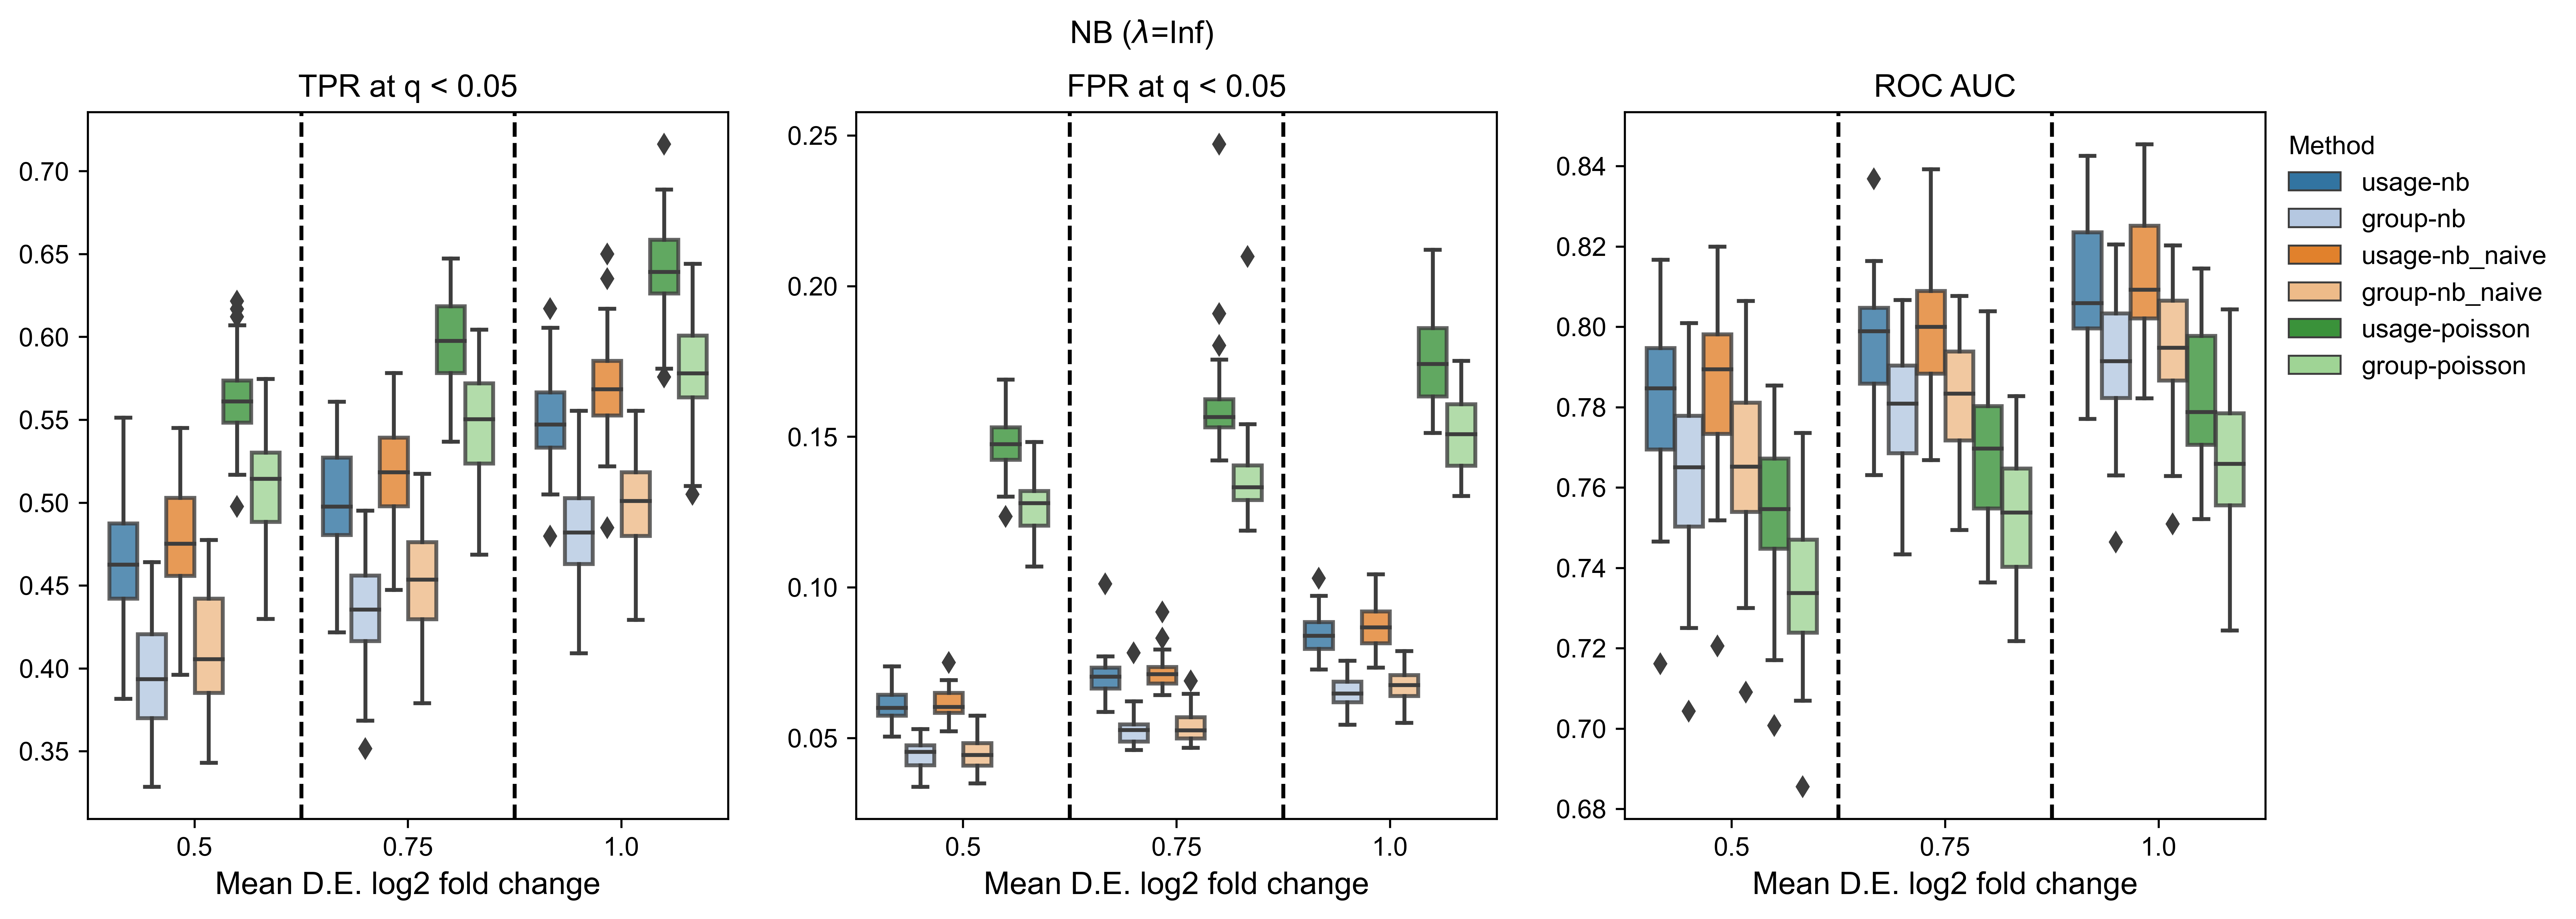

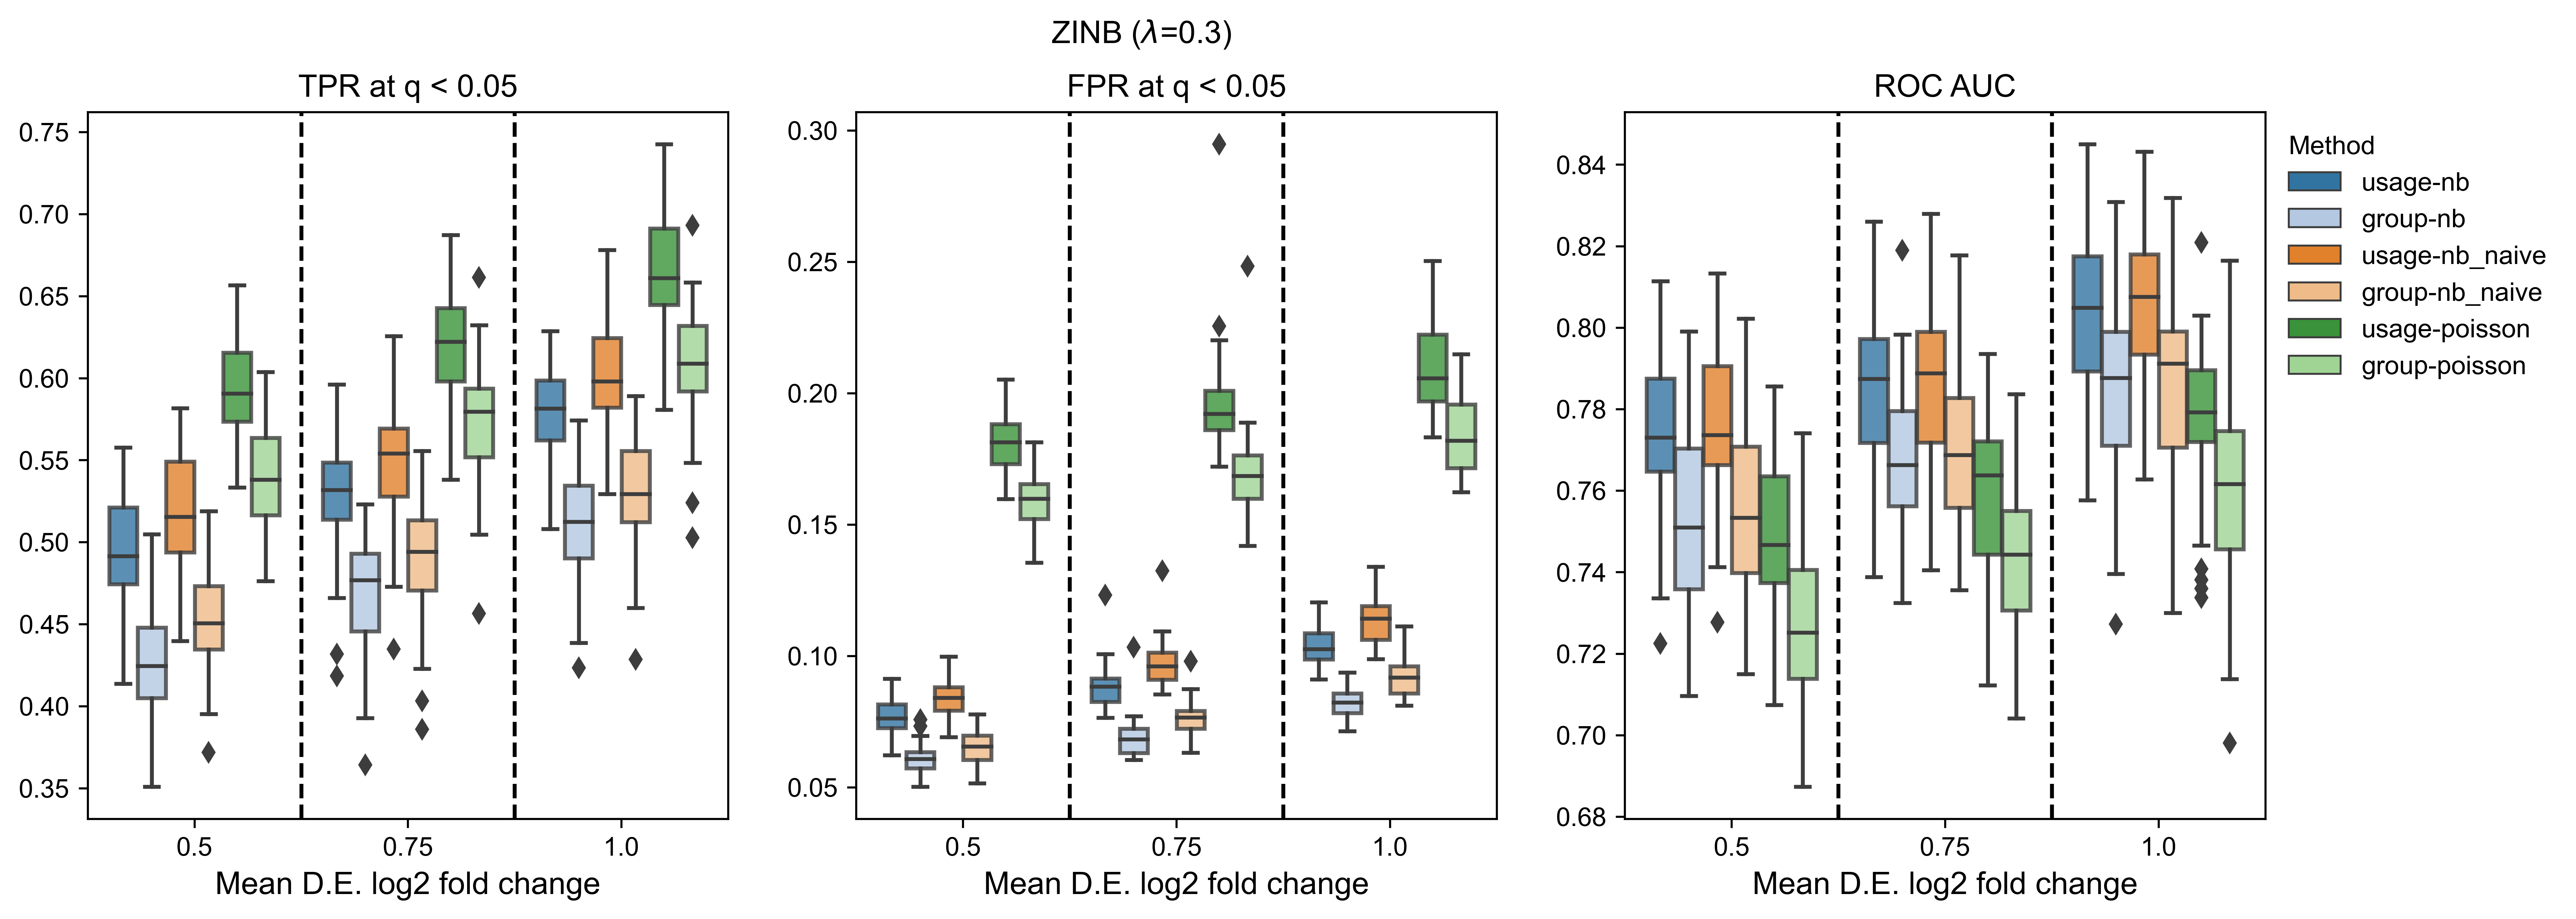

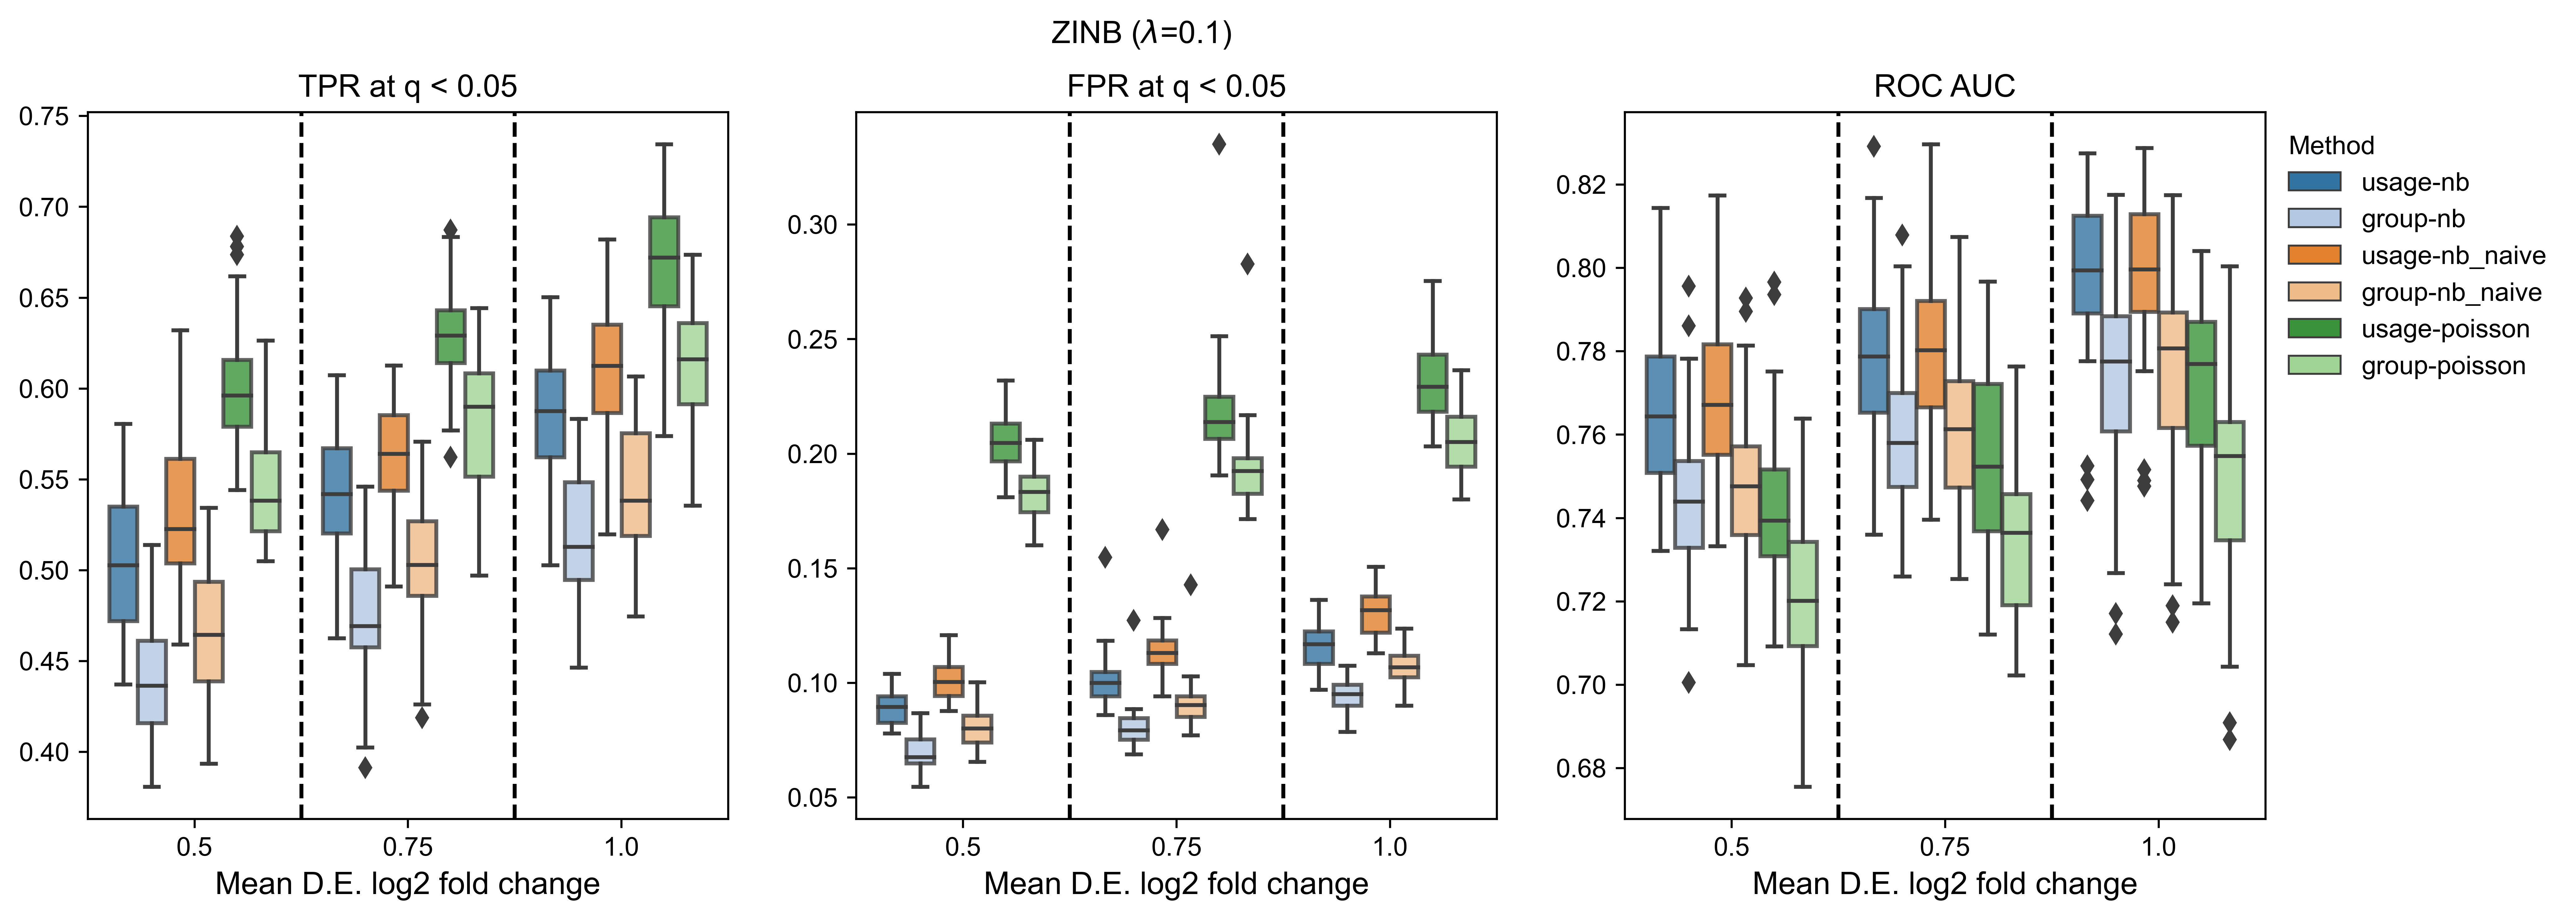

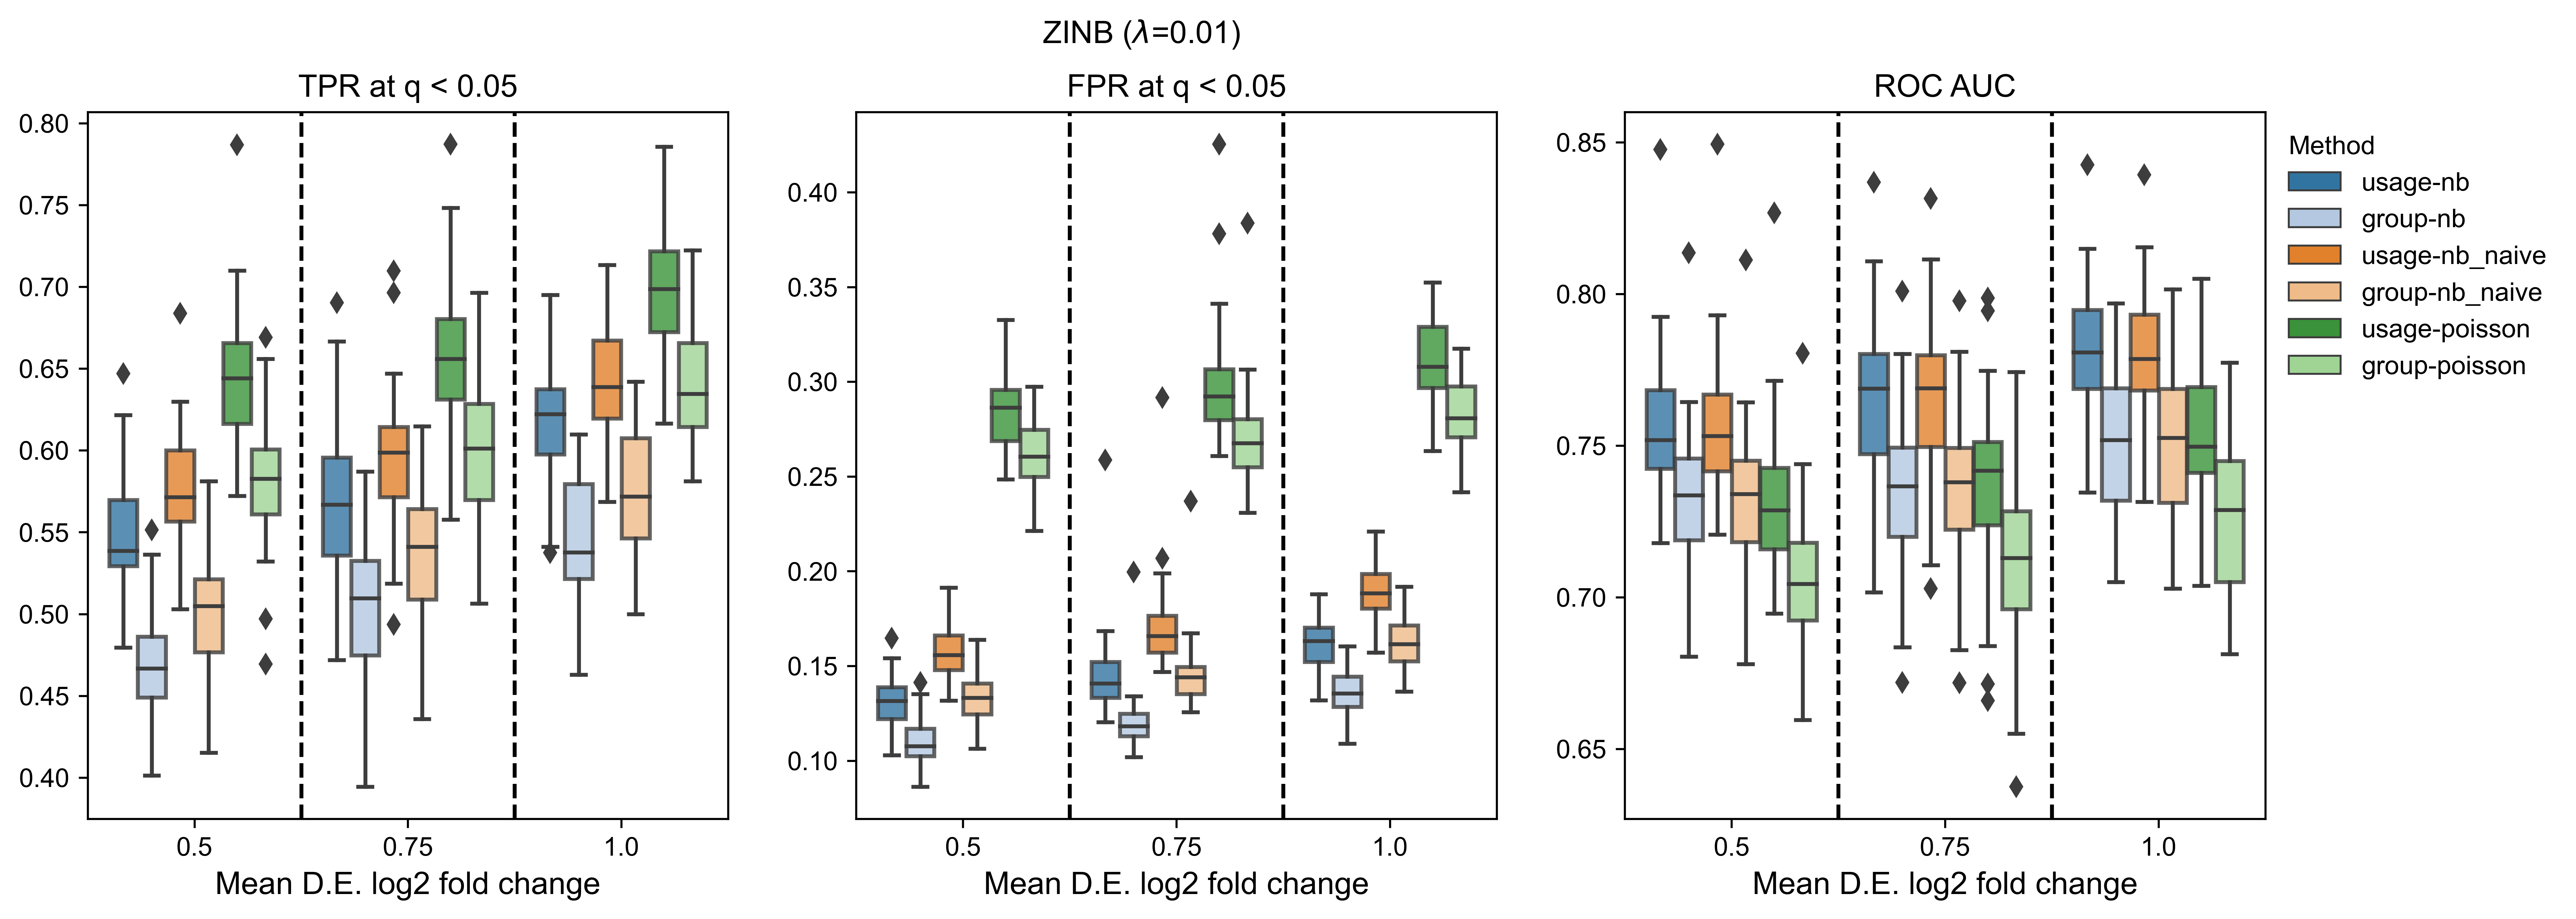

In [31]:
lams = ['Inf', '0.3', '0.1', '0.01']

for lam in lams:

    accuracy_u_new_flat_fn = '../Simulation_no_results/DEG_eval_usage_%s.npz' % lam
    accuracy_d_new_flat_fn = '../Simulation_no_results/DEG_eval_usage_d_%s.npz' % lam
    accuracy_u_new_flat = load_df_from_npz(accuracy_u_new_flat_fn)
    accuracy_d_new_flat = load_df_from_npz(accuracy_d_new_flat_fn)

    # Merge two datasets vertically
    accuracy_flat = pd.concat([accuracy_u_new_flat, accuracy_d_new_flat])
    # Get a subset that uses offset
    accuracy_flat = accuracy_flat[accuracy_flat.offset]
    acc_perType = accuracy_flat.copy()
    acc_perType.method = ["%s-%s"%(acc_perType.method.values[i], acc_perType.test_use.values[i]) 
                          for i in range(acc_perType.shape[0])]
    acc_perType.method = acc_perType.method.astype('category')
    methods = ['usage-nb', 'group-nb', 'usage-nb_naive', 'group-nb_naive', 'usage-poisson', 'group-poisson']
    acc_perType.method = acc_perType.method.cat.reorder_categories(methods)

    legend_len = len(acc_perType.method.value_counts())
    (fig, ax) = plt.subplots(1,3,figsize=(15, 5), dpi=600)
    alpha = 0.8

    sns.boxplot(x='noiselevel', y='power', hue='method', data=acc_perType, 
                ax=ax[0], boxprops=dict(alpha=alpha), palette='tab20')
    ax[0].legend([],[],frameon=False)
    ax[0].set_xlabel('Mean D.E. log2 fold change', fontsize=12)
    ax[0].set_ylabel('', fontsize=12)
    ax[0].set_title('TPR at q < 0.05', fontsize=12)
    ax[0].axvline(0.5, color='black', linestyle='--')
    ax[0].axvline(1.5, color='black', linestyle='--')

    sns.boxplot(x='noiselevel', y='type I error rate', hue='method', data=acc_perType, 
                ax=ax[1], boxprops=dict(alpha=alpha), palette='tab20')
    ax[1].legend([],[],frameon=False)
    ax[1].set_xlabel('Mean D.E. log2 fold change', fontsize=12)
    ax[1].set_ylabel('', fontsize=12)
    ax[1].set_title('FPR at q < 0.05', fontsize=12)
    ax[1].axvline(0.5, color='black', linestyle='--')
    ax[1].axvline(1.5, color='black', linestyle='--')

    sns.boxplot(x='noiselevel', y='ROC AUC', hue='method', data=acc_perType, 
                ax=ax[2], boxprops=dict(alpha=alpha), palette='tab20')
    handles, labels = ax[2].get_legend_handles_labels()
    leg = ax[2].legend(handles[0:legend_len], labels[0:legend_len], bbox_to_anchor=(1, 1), loc=2, 
                 title='Method', frameon=False)
    leg._legend_box.align = "left"
    ax[2].set_xlabel('Mean D.E. log2 fold change', fontsize=12)
    ax[2].set_ylabel('', fontsize=12)
    ax[2].set_title('ROC AUC', fontsize=12)
    ax[2].axvline(0.5, color='black', linestyle='--')
    ax[2].axvline(1.5, color='black', linestyle='--')

    if lam == 'Inf':
        dist = 'NB'
    else:
        dist = 'ZINB'
    plt.suptitle('%s ($\lambda$=%s)'%(dist,lam))

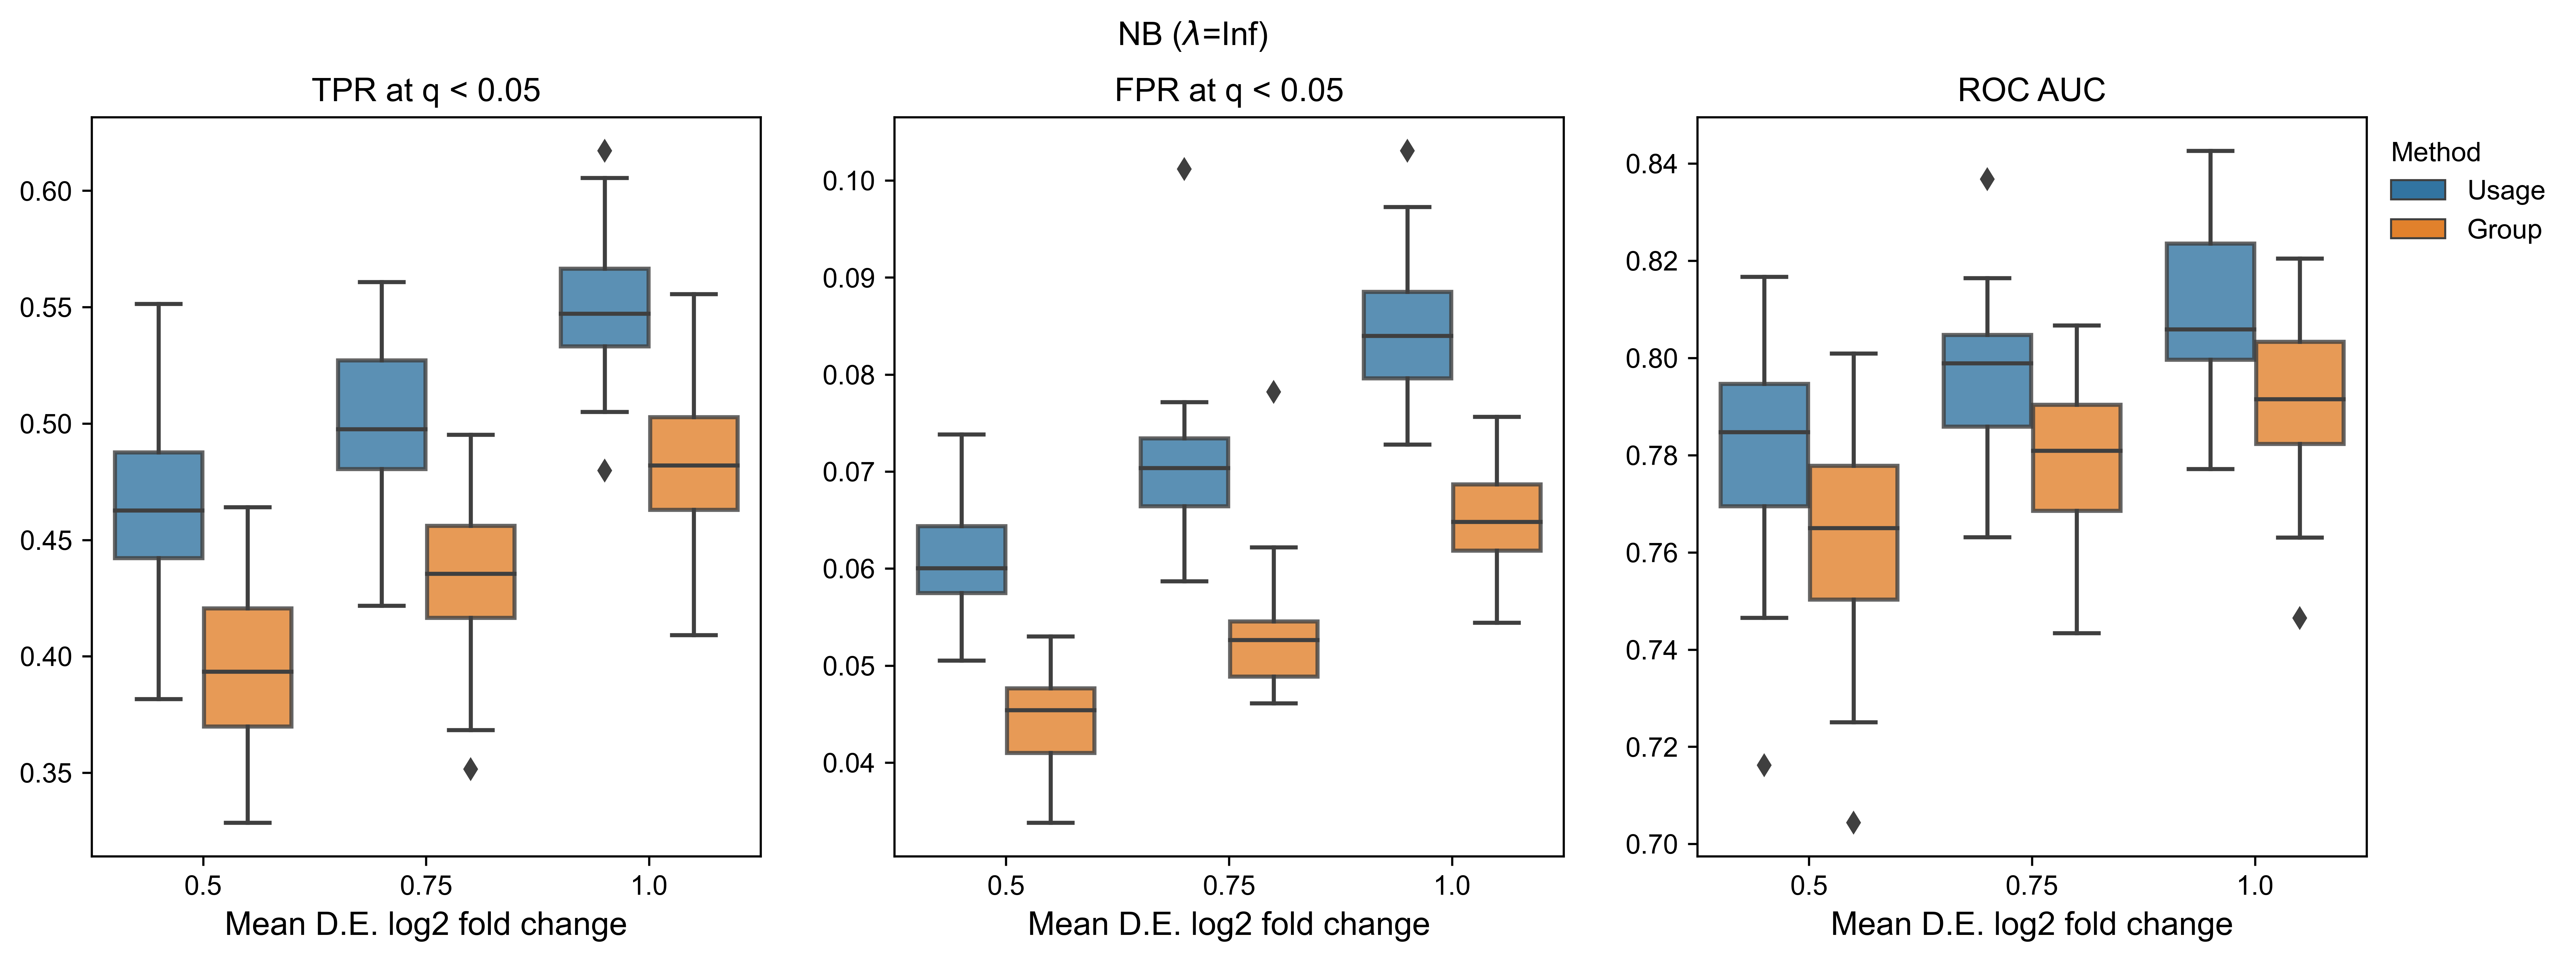

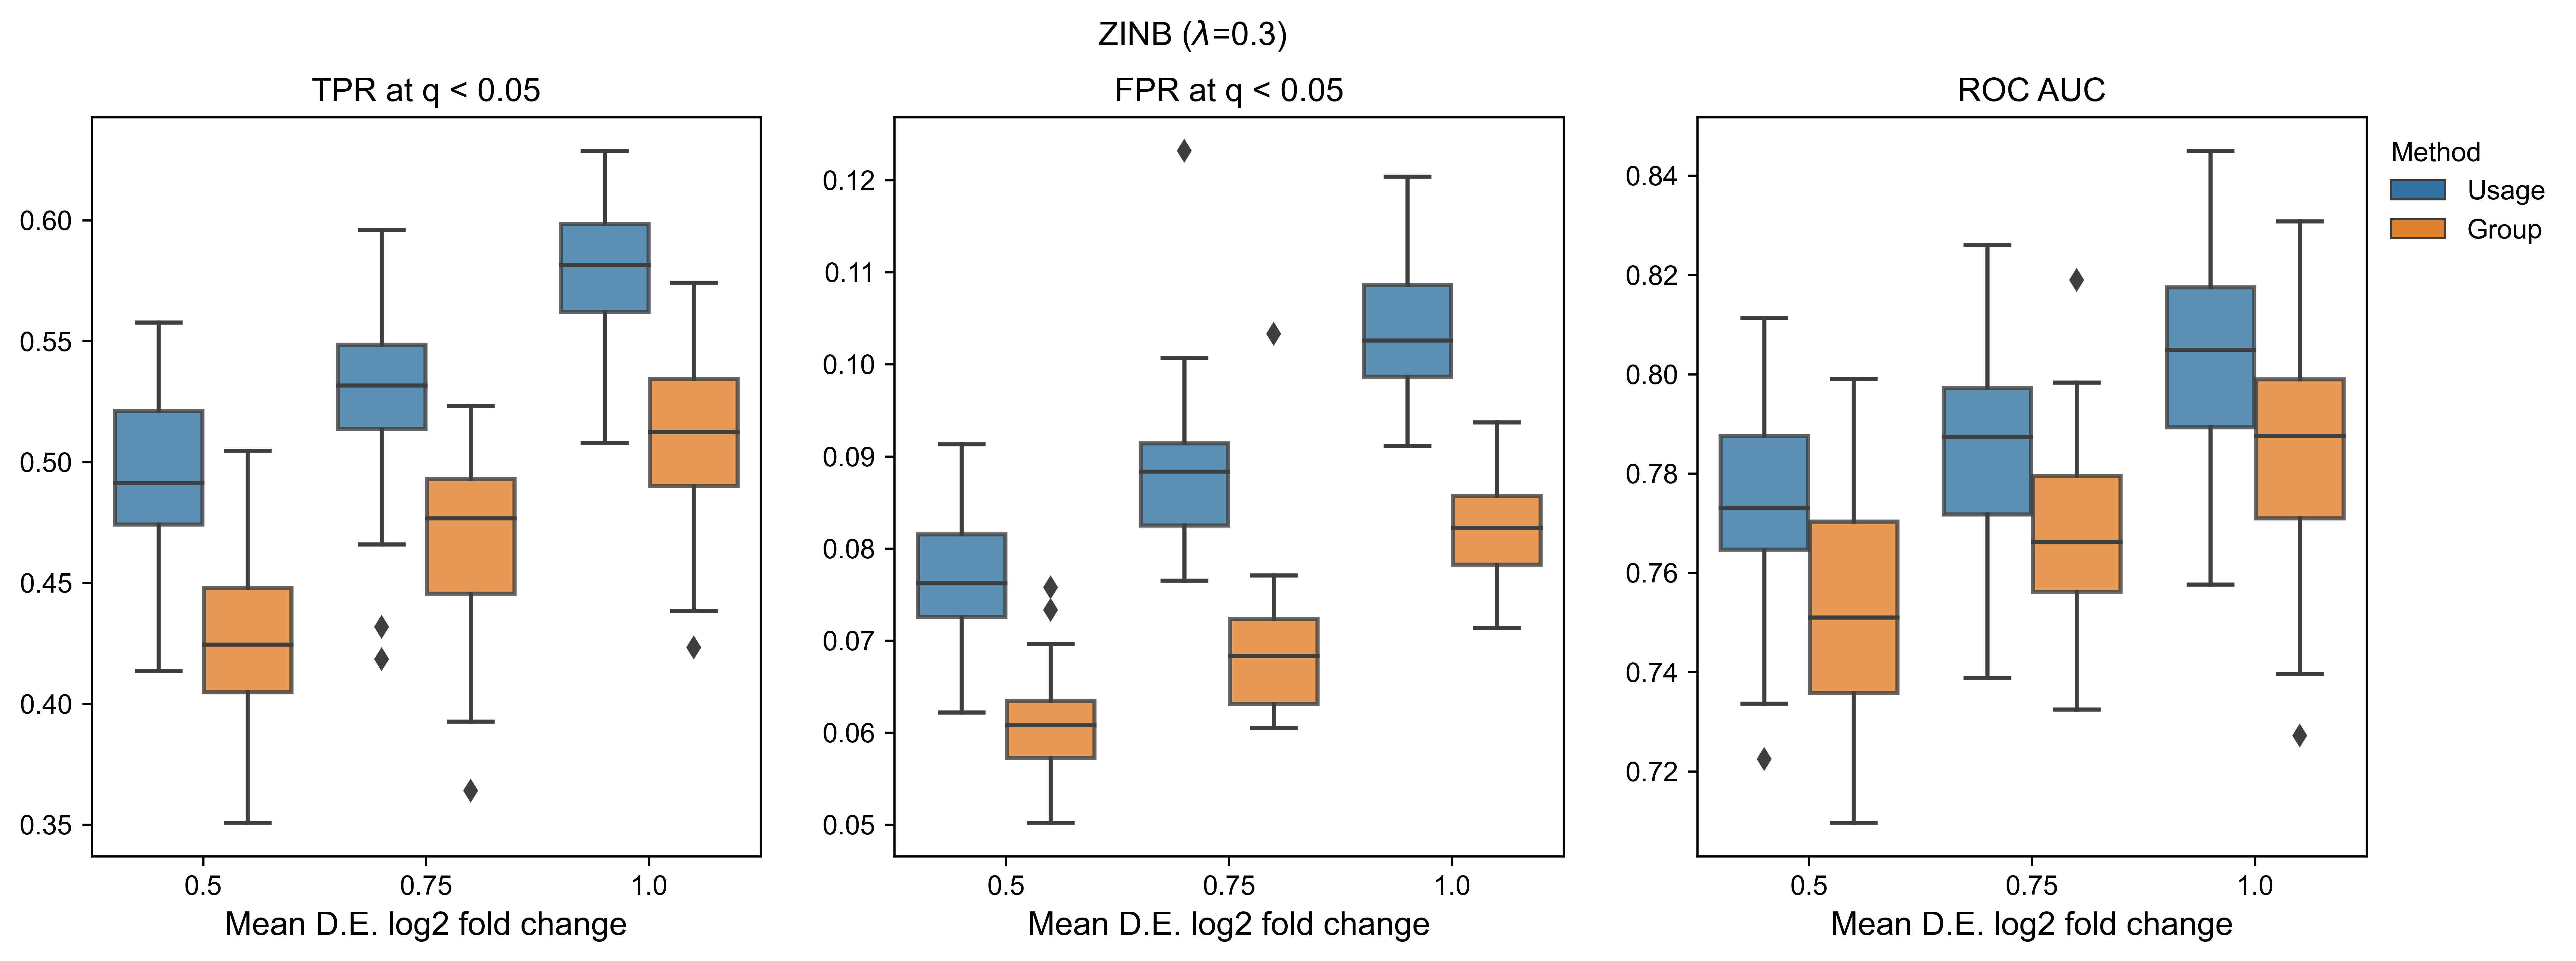

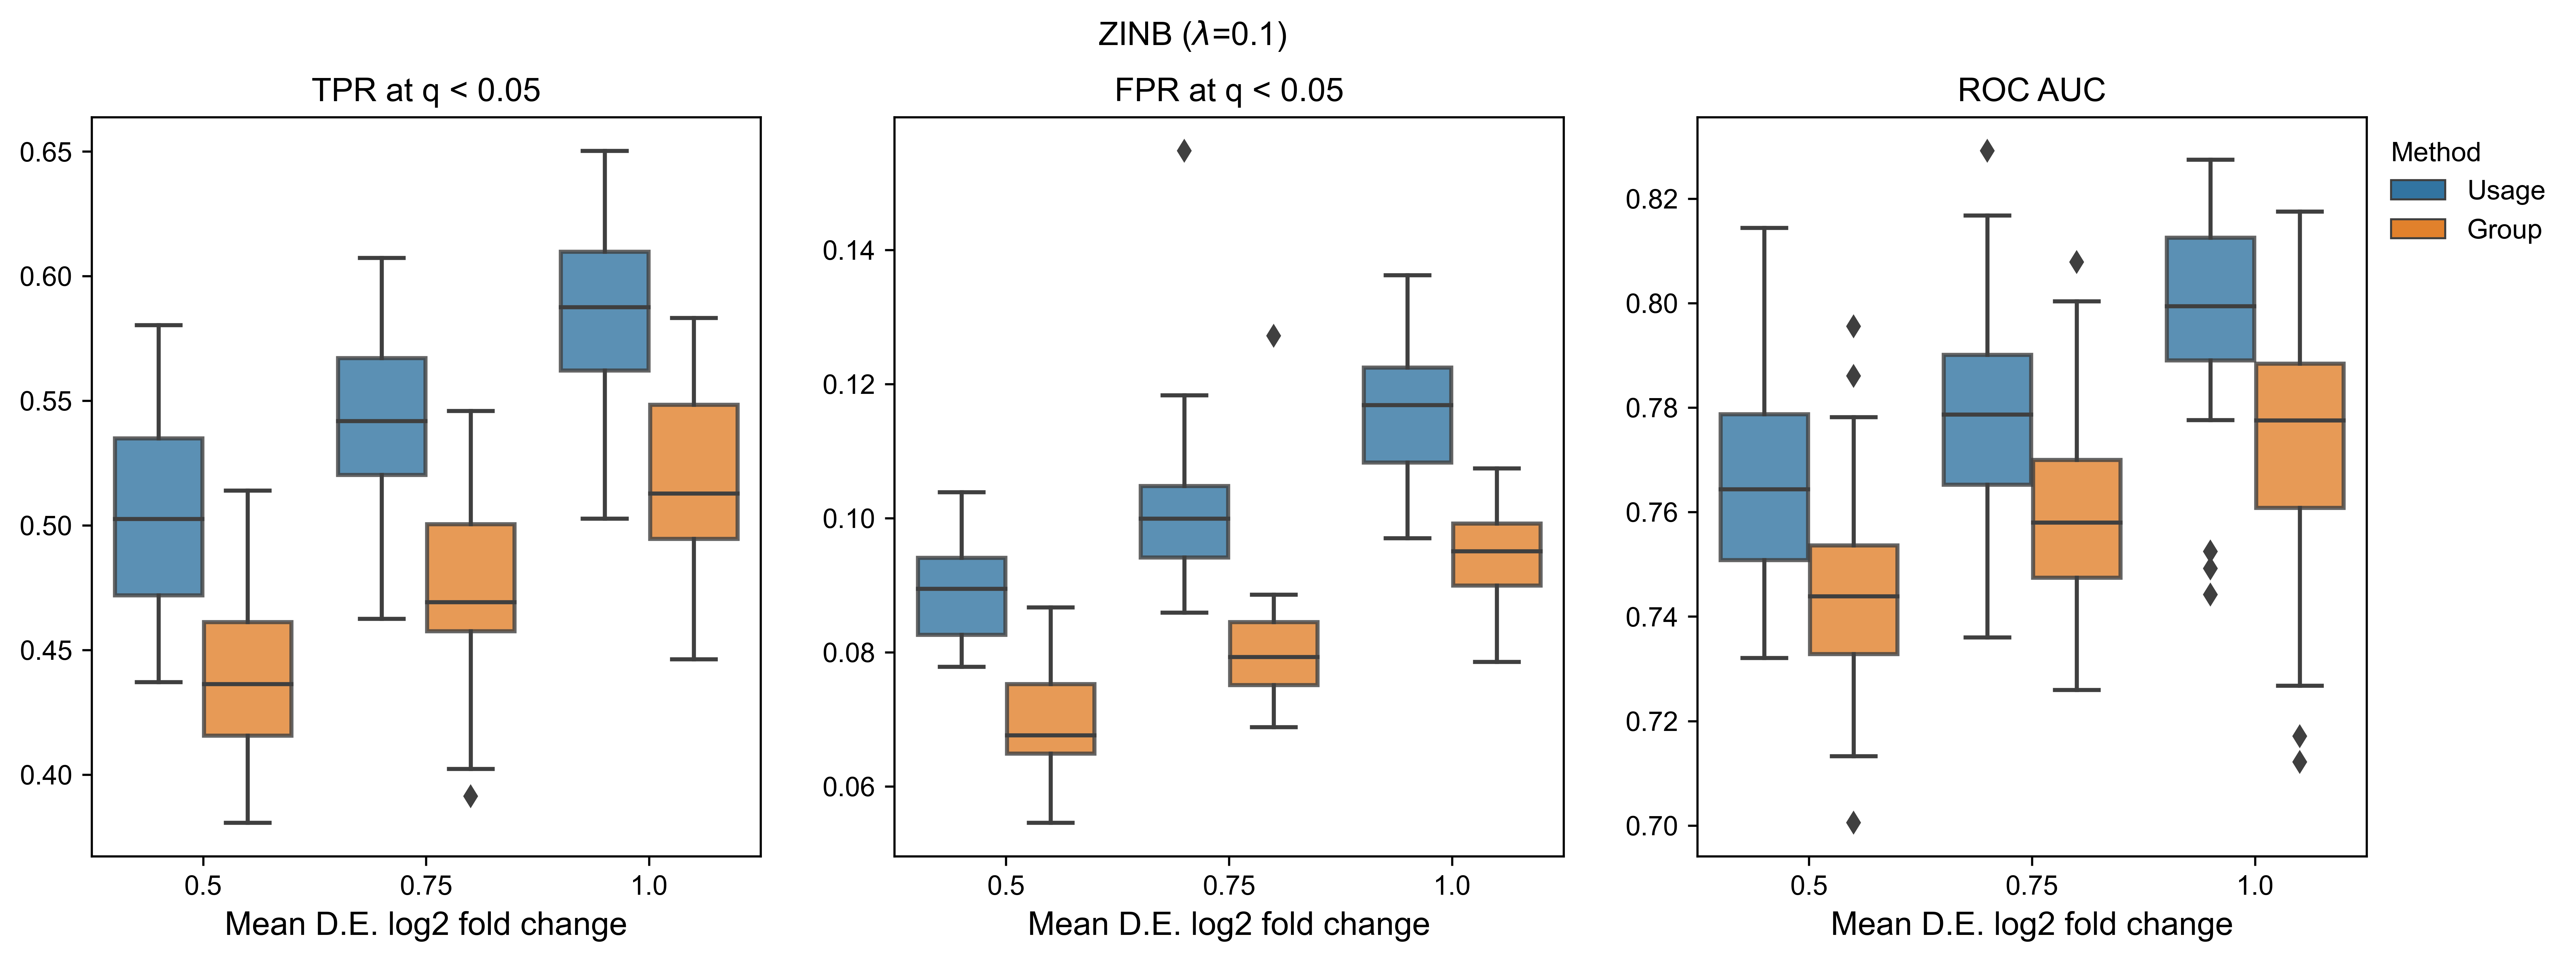

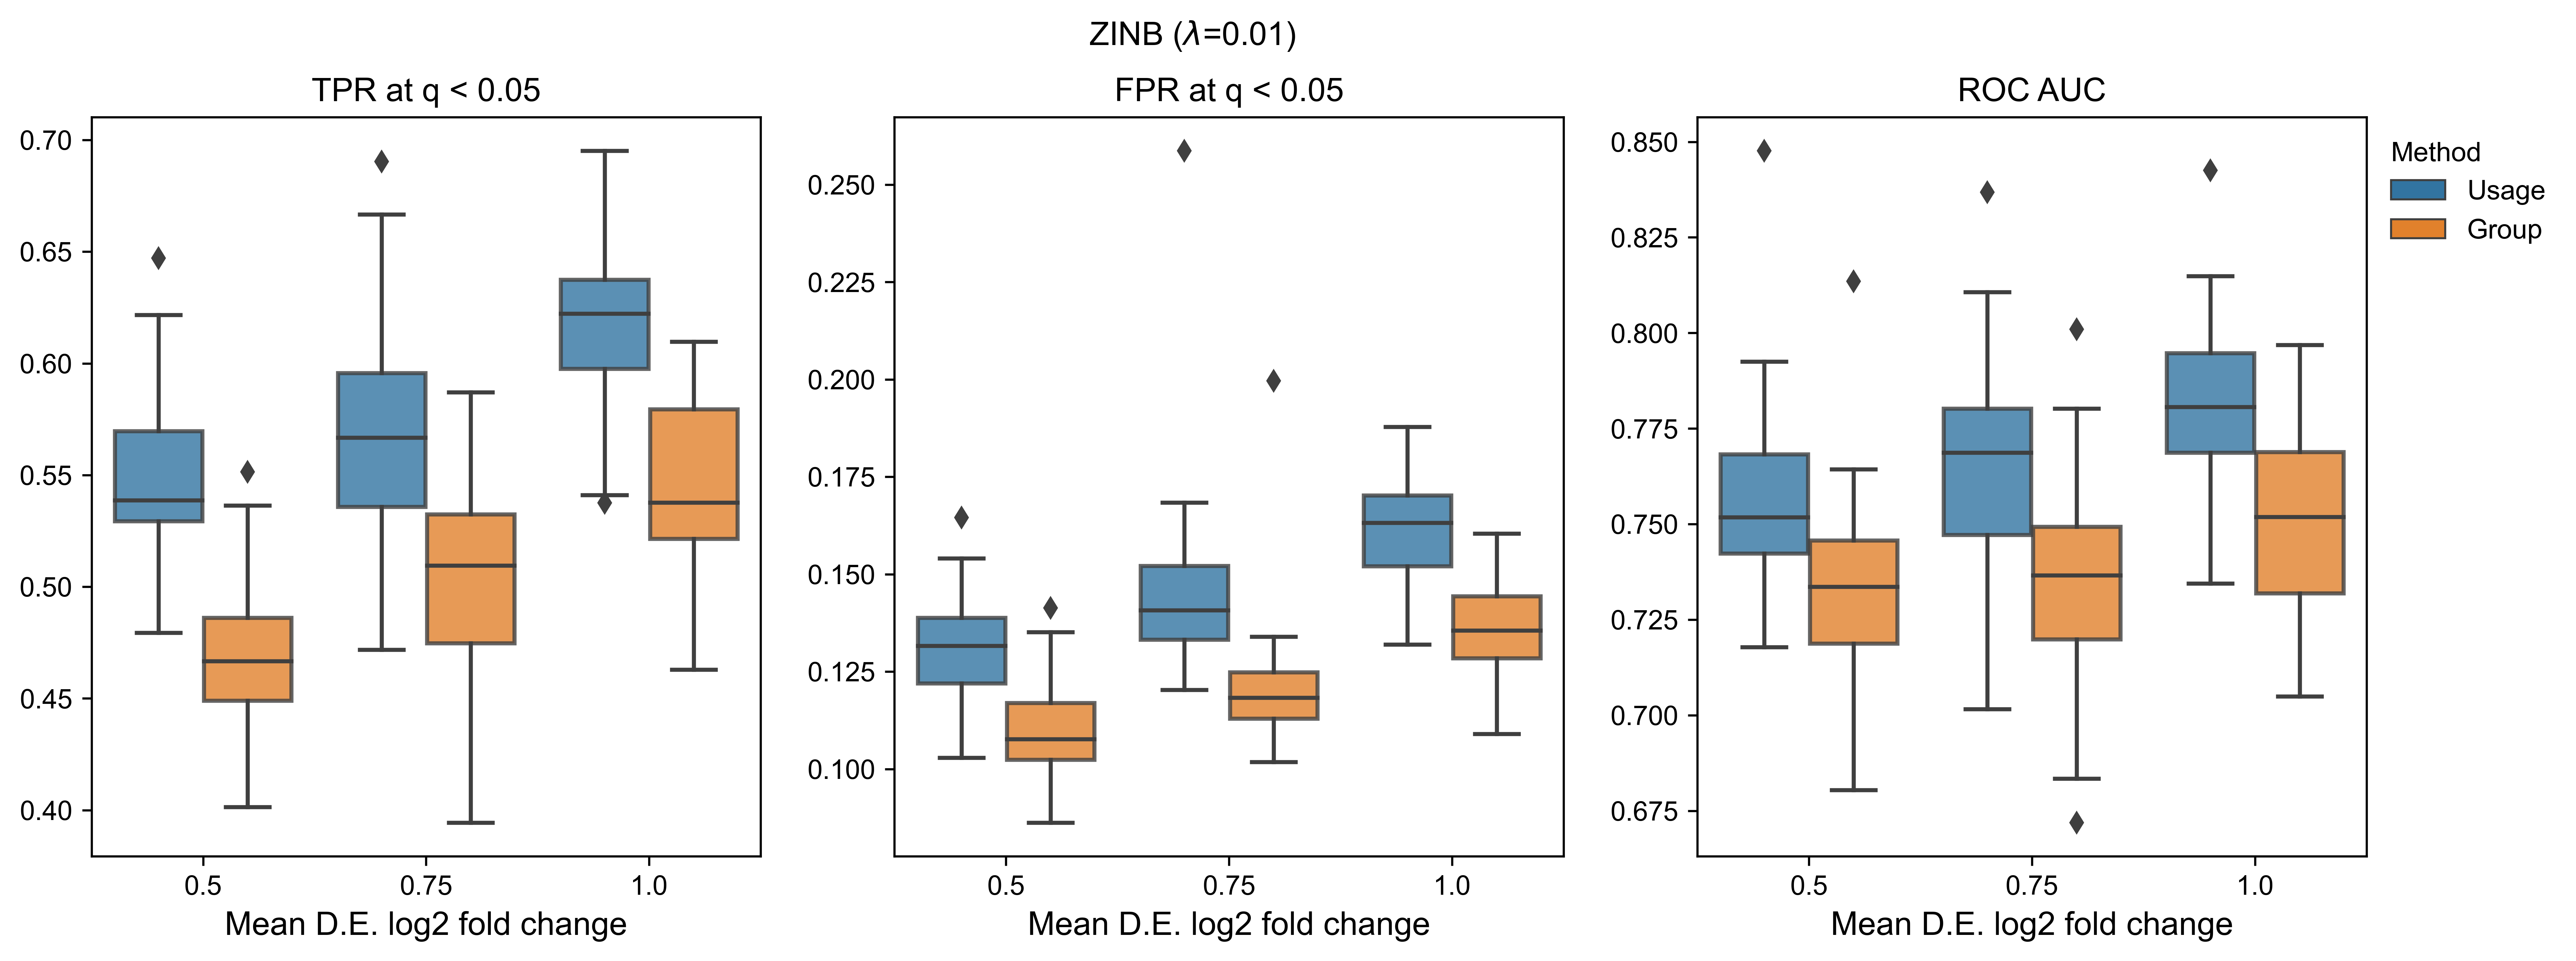

In [32]:
lams = ['Inf', '0.3', '0.1', '0.01']

for lam in lams:

    accuracy_u_new_flat_fn = '../Simulation_no_results/DEG_eval_usage_%s.npz' % lam
    accuracy_d_new_flat_fn = '../Simulation_no_results/DEG_eval_usage_d_%s.npz' % lam
    accuracy_u_new_flat = load_df_from_npz(accuracy_u_new_flat_fn)
    accuracy_d_new_flat = load_df_from_npz(accuracy_d_new_flat_fn)

    # Get only nb and with offset
    accuracy_u_flat = accuracy_u_new_flat[(accuracy_u_new_flat.test_use=='nb') & (accuracy_u_new_flat.offset)]
    accuracy_d_flat = accuracy_d_new_flat[(accuracy_d_new_flat.test_use=='nb') & (accuracy_d_new_flat.offset)]
    acc_flat = pd.concat([accuracy_u_flat, accuracy_d_flat])
    acc_perType = acc_flat.copy()
    acc_perType.method[acc_perType.method=='group'] = 'Group'
    acc_perType.method[acc_perType.method=='usage'] = 'Usage'

    legend_len = len(acc_perType.method.value_counts())
    (fig, ax) = plt.subplots(1,3,figsize=(15, 5), dpi=600)
    alpha = 0.8

    sns.boxplot(x='noiselevel', y='power', hue='method', data=acc_perType, 
                ax=ax[0], boxprops=dict(alpha=alpha))
    ax[0].legend([],[],frameon=False)
    ax[0].set_xlabel('Mean D.E. log2 fold change', fontsize=12)
    ax[0].set_ylabel('', fontsize=12)
    ax[0].set_title('TPR at q < 0.05', fontsize=12)

    sns.boxplot(x='noiselevel', y='type I error rate', hue='method', data=acc_perType, 
                ax=ax[1], boxprops=dict(alpha=alpha))
    ax[1].legend([],[],frameon=False)
    ax[1].set_xlabel('Mean D.E. log2 fold change', fontsize=12)
    ax[1].set_ylabel('', fontsize=12)
    ax[1].set_title('FPR at q < 0.05', fontsize=12)

    sns.boxplot(x='noiselevel', y='ROC AUC', hue='method', data=acc_perType, 
                ax=ax[2], boxprops=dict(alpha=alpha))
    handles, labels = ax[2].get_legend_handles_labels()
    leg = ax[2].legend(handles[0:legend_len], labels[0:legend_len], bbox_to_anchor=(1, 1), loc=2, 
                 title='Method', frameon=False)
    leg._legend_box.align = "left"
    ax[2].set_xlabel('Mean D.E. log2 fold change', fontsize=12)
    ax[2].set_ylabel('', fontsize=12)
    ax[2].set_title('ROC AUC', fontsize=12)

    if lam == 'Inf':
        dist = 'NB'
    else:
        dist = 'ZINB'
    plt.suptitle('%s ($\lambda$=%s)'%(dist,lam))